🚀 [Step 1] 고성능 객체 분리 (BiRefNet)...

🚀 [Step 2] 고해상도 배경 생성 (Juggernaut XL + VAE)...


100%|██████████| 50/50 [00:18<00:00,  2.63it/s]



🚀 [Step 3] 정밀 합성 및 듀얼 그림자 생성...

🚀 [Step 4] ControlNet 기반 하이엔드 리터칭 (핵심 단계)...


100%|██████████| 22/22 [00:12<00:00,  1.77it/s]



🚀 [Step 5] 최종 텍스트 디자인 적용...


/tmp/ipykernel_82912/2887188628.py:59: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_82912/2887188628.py:59: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_82912/2887188628.py:59: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_82912/2887188628.py:59: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_82912/2887188628.py:59: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_82912/2887188628.py:59: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_82912/2887188628.py:59: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  pl


모든 작업 완료. 결과 이미지를 확인하세요.


/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/IPython/core/pyla

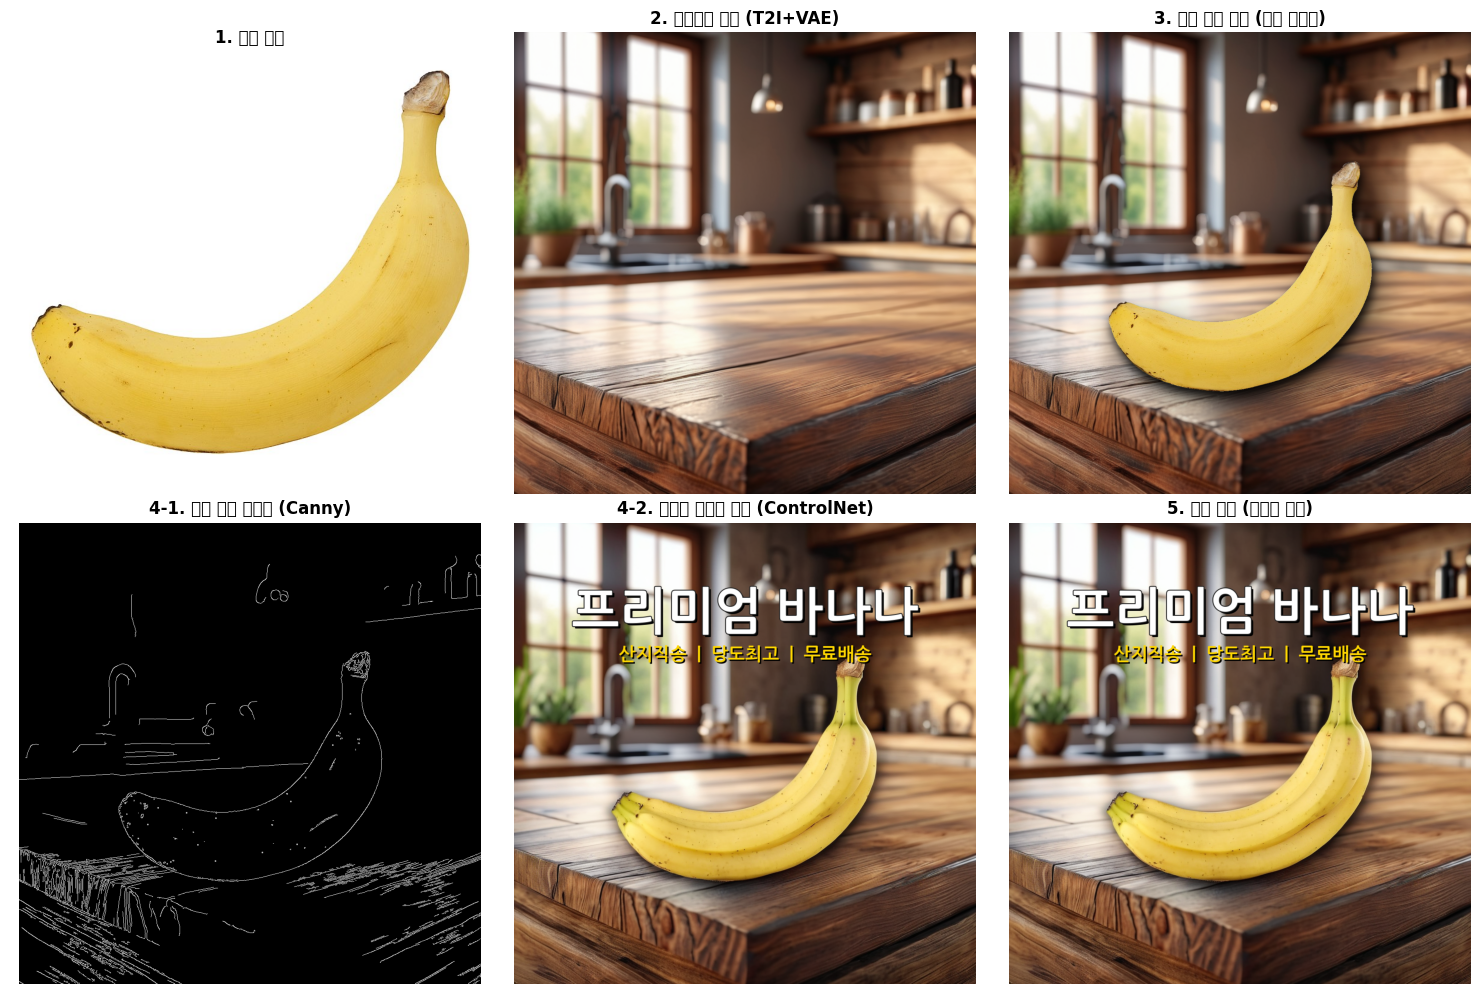

In [14]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps
import cv2
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
from diffusers import (
    StableDiffusionXLControlNetImg2ImgPipeline,
    ControlNetModel,
    AutoencoderKL,
    AutoPipelineForText2Image,
    DPMSolverMultistepScheduler
)
from diffusers.utils import load_image
import matplotlib.pyplot as plt
import math

# ==========================================
# ⚙️ 하이엔드 설정
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.float16

# 1. 모델: 실사 최강 Juggernaut XL v9
MODEL_ID = "RunDiffusion/Juggernaut-XL-v9"
# 2. VAE: SDXL의 물 빠진 색감을 보정하는 필수 요소
VAE_ID = "madebyollin/sdxl-vae-fp16-fix"
# 3. ControlNet: 형태를 고정해주는 핵심 모델 (Canny)
CONTROLNET_ID = "diffusers/controlnet-canny-sdxl-1.0"

def flush():
    """VRAM 메모리 적극적 해제"""
    gc.collect()
    torch.cuda.empty_cache()

def download_font(font_name="NanumGothicBold.ttf"):
    # ... (이전과 동일)
    url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
    if not os.path.exists(font_name) or os.path.getsize(font_name) < 1000:
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

def plot_steps(step_images):
    # ... (이전과 동일한 시각화 함수)
    n = len(step_images)
    cols = 3
    rows = math.ceil(n / cols)
    plt.figure(figsize=(15, 5 * rows))
    for i, (img, title) in enumerate(step_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(title, fontsize=12, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    print("\n모든 작업 완료. 결과 이미지를 확인하세요.")
    plt.show()

# ==========================================
# 🛠️ 유틸리티: Canny 엣지 추출
# ==========================================
def get_canny_image(image):
    image = np.array(image)
    image = cv2.Canny(image, 100, 200)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    return Image.fromarray(image)

# ==========================================
# ✂️ STEP 1: 객체 정밀 분리 (BiRefNet)
# ==========================================
# ==========================================
# ✂️ STEP 1: 객체 정밀 분리 (BiRefNet) - 수정됨
# ==========================================
def extract_object(image_path):
    print("🚀 [Step 1] 고성능 객체 분리 (BiRefNet)...")
    birefnet = AutoModelForImageSegmentation.from_pretrained(
        "ZhengPeng7/BiRefNet", trust_remote_code=True
    )
    birefnet.to(DEVICE)
    birefnet.eval()

    # 1. 원본 로드 및 크기 저장
    original_img = load_image(image_path).convert("RGB")
    W, H = original_img.size

    # 2. 모델 입력용 리사이즈 (강제 1024x1024)
    # 수정 이유: 705px 같은 애매한 숫자가 들어가면 에러가 발생하므로,
    # 모델이 좋아하는 1024x1024로 고정해서 처리합니다.
    img_for_model = original_img.resize((1024, 1024), Image.LANCZOS)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(img_for_model).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        preds = birefnet(input_tensor)[-1].sigmoid().cpu()
    
    pred = preds[0].squeeze()
    
    # 3. 마스크를 다시 원본 크기(W, H)로 복원
    # 이렇게 해야 바나나가 찌그러지지 않습니다.
    mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
    mask = mask.point(lambda x: 255 if x > 120 else 0) 
    
    # 4. 원본 이미지에서 누끼 따기
    foreground = original_img.copy()
    foreground.putalpha(mask)
    
    del birefnet, input_tensor
    flush()
    
    return original_img, foreground, mask

# ==========================================
# 🎨 STEP 2: 고해상도 배경 생성 (T2I + VAE)
# ==========================================
def generate_new_background():
    print("\n🚀 [Step 2] 고해상도 배경 생성 (Juggernaut XL + VAE)...")
    # VAE 로드 (색감 보정)
    vae = AutoencoderKL.from_pretrained(VAE_ID, torch_dtype=TORCH_DTYPE).to(DEVICE)
    
    pipe = AutoPipelineForText2Image.from_pretrained(
        MODEL_ID, torch_dtype=TORCH_DTYPE, variant="fp16", vae=vae
    ).to(DEVICE)
    # 고품질 스케줄러 적용
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True)
    
    prompt = (
        "Professional product photography, macro shot, front view, "
        "empty rustic aged wooden table top surface with rich texture, "
        "blurred warm sunny kitchen island background with beautiful bokeh, "
        "soft volumetric natural window light from left, highly detailed, 8k, masterpiece"
    )
    negative_prompt = "banana, fruit, food, messy, ugly, text, watermark, lowres, smooth"
    
    # 스텝 수 증가 (35 -> 50) 및 높은 가이던스
    bg_image = pipe(
        prompt=prompt, negative_prompt=negative_prompt,
        width=1024, height=1024, 
        num_inference_steps=50, guidance_scale=7.5
    ).images[0]
    
    del pipe, vae
    flush()
    return bg_image

# ==========================================
# 🌑 STEP 3: 수동 정밀 합성 (듀얼 그림자)
# ==========================================
def composite_images_pro(bg_img, fg_img, mask):
    print("\n🚀 [Step 3] 정밀 합성 및 듀얼 그림자 생성...")
    bg_w, bg_h = bg_img.size
    fg_w, fg_h = fg_img.size
    
    # 크기 및 위치 계산
    scale_factor = 0.80
    new_w, new_h = int(fg_w * scale_factor), int(fg_h * scale_factor)
    fg_resized = fg_img.resize((new_w, new_h), Image.LANCZOS)
    mask_resized = mask.resize((new_w, new_h), Image.LANCZOS)
    paste_x, paste_y = (bg_w - new_w) // 2, (bg_h - new_h) // 2 + 30

    # 💡 듀얼 그림자 시스템
    # 1. Contact Shadow (접지면: 진하고 좁게)
    contact_shadow = Image.new("RGBA", (bg_w, bg_h), (0,0,0,0))
    contact_shadow.paste((0,0,0,220), (paste_x + 5, paste_y + 15), mask=mask_resized)
    contact_shadow = contact_shadow.filter(ImageFilter.GaussianBlur(10))

    # 2. Soft Shadow (주변부: 연하고 넓게)
    soft_shadow = Image.new("RGBA", (bg_w, bg_h), (0,0,0,0))
    soft_shadow.paste((0,0,0,150), (paste_x + 20, paste_y + 40), mask=mask_resized)
    # 눕히기 효과를 위한 아핀 변환 (선택 사항, 복잡도 증가로 일단 제외하고 블러로 처리)
    soft_shadow = soft_shadow.filter(ImageFilter.GaussianBlur(40))

    # 합성: 배경 -> 소프트 그림자 -> 컨택트 그림자 -> 바나나
    composite = bg_img.convert("RGBA")
    composite = Image.alpha_composite(composite, soft_shadow)
    composite = Image.alpha_composite(composite, contact_shadow)
    
    fg_layer = Image.new("RGBA", (bg_w, bg_h), (0, 0, 0, 0))
    fg_layer.paste(fg_resized, (paste_x, paste_y), mask=fg_resized)
    composite = Image.alpha_composite(composite, fg_layer)
    
    return composite.convert("RGB")

# ==========================================
# 🔥 STEP 4: ControlNet 기반 구조적 리터칭 🔥
# ==========================================
def refine_with_controlnet(composite_image):
    print("\n🚀 [Step 4] ControlNet 기반 하이엔드 리터칭 (핵심 단계)...")
    
    # 1. Canny 엣지 맵 추출 (형태 고정용 가이드)
    canny_image = get_canny_image(composite_image)
    
    # 2. 모델 로드 (ControlNet + Img2Img + VAE)
    controlnet = ControlNetModel.from_pretrained(CONTROLNET_ID, torch_dtype=TORCH_DTYPE).to(DEVICE)
    vae = AutoencoderKL.from_pretrained(VAE_ID, torch_dtype=TORCH_DTYPE).to(DEVICE)
    
    pipe = StableDiffusionXLControlNetImg2ImgPipeline.from_pretrained(
        MODEL_ID, controlnet=controlnet, vae=vae, torch_dtype=TORCH_DTYPE, variant="fp16"
    ).to(DEVICE)
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True)

    prompt = (
        "Professional product photography of premium bananas on a rustic wooden table, "
        "hyperrealistic, detailed wood grain texture, cinematic lighting, "
        "photorealistic reflections and realistic shadows, 8k masterpiece"
    )
    # 부정 프롬프트 강화
    negative_prompt = "cartoon, painting, illustration, deformed, ugly, blur, noisy, low quality, distortion"

    # 💡 핵심 파라미터
    # strength: 0.45 (꽤 높게 주어 빛과 질감을 확실히 재구성)
    # controlnet_conditioning_scale: 1.0 (엣지 가이드를 강하게 따라 형태 왜곡 방지)
    final_img = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=composite_image,         # 원본 색감 참조
        control_image=canny_image,     # 형태 고정 가이드
        strength=0.45,                 # 리터칭 강도 (높을수록 리얼해지지만 왜곡 위험, CN으로 방어)
        controlnet_conditioning_scale=1.0,
        num_inference_steps=50,        # 고품질 스텝
        guidance_scale=8.0
    ).images[0]
    
    del pipe, controlnet, vae
    flush()
    return final_img, canny_image

# ==========================================
# ✍️ STEP 5: 텍스트 디자인 (동일)
# ==========================================
def add_text_design_final(image):
    print("\n🚀 [Step 5] 최종 텍스트 디자인 적용...")
    font_path = download_font()
    draw = ImageDraw.Draw(image)
    W, H = image.size
    
    font_main = ImageFont.truetype(font_path, int(H * 0.11))
    font_sub = ImageFont.truetype(font_path, int(H * 0.04))
    txt_main = "프리미엄 바나나"
    txt_sub = "산지직송  |  당도최고  |  무료배송"
    
    def get_size(text, font):
        bbox = draw.textbbox((0,0), text, font=font)
        return bbox[2]-bbox[0], bbox[3]-bbox[1]
    
    wm, hm = get_size(txt_main, font_main)
    ws, hs = get_size(txt_sub, font_sub)
    x_main, y_main = (W - wm) / 2, H * 0.14
    x_sub, y_sub = (W - ws) / 2, y_main + hm + 22
    
    draw.text((x_main+5, y_main+5), txt_main, font=font_main, fill=(0,0,0,120))
    draw.text((x_main, y_main), txt_main, font=font_main, fill="white", stroke_width=2, stroke_fill="#222")
    draw.text((x_sub+3, y_sub+3), txt_sub, font=font_sub, fill=(0,0,0,120))
    draw.text((x_sub, y_sub), txt_sub, font=font_sub, fill="#FFD700")
    return image

# ==========================================
# 🚀 메인 실행 (하이엔드 워크플로우)
# ==========================================
def process_high_end_ad(image_path):
    flush()
    step_images = []

    # 1. 누끼
    original, foreground, mask = extract_object(image_path)
    step_images.append((original, "1. 원본 입력"))

    # 2. 배경 생성 (고품질 설정)
    bg_clean = generate_new_background()
    step_images.append((bg_clean, "2. 고해상도 배경 (T2I+VAE)"))
    
    # 3. 정밀 합성 (듀얼 그림자)
    composited_pro = composite_images_pro(bg_clean, foreground, mask)
    step_images.append((composited_pro, "3. 정밀 수동 합성 (듀얼 그림자)"))
    
    # 4. ControlNet 리터칭 (핵심)
    refined, canny_map = refine_with_controlnet(composited_pro)
    step_images.append((canny_map, "4-1. 형태 고정 가이드 (Canny)"))
    step_images.append((refined, "4-2. 구조적 리터칭 완료 (ControlNet)"))
    
    # 5. 텍스트
    final = add_text_design_final(refined)
    step_images.append((final, "5. 최종 완성 (텍스트 포함)"))
    
    final.save("final_high_end_ad.png")
    plot_steps(step_images)

# 실행
process_high_end_ad("image.png")